<a href="https://colab.research.google.com/github/Saish31/AIML/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Pneumonia Detection with Grad-CAM Explainability</h1>

Objective: To build and fine-tune a deep learning model that can accurately classify chest X-rays as either "Normal" or "Pneumonia," and to implement an explainability technique (Grad-CAM) to visualize what features the model uses to make its decisions.

In [ ]:
from google.colab import files

print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

In [ ]:
# Set up the Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the dataset
!unzip -q chest-xray-pneumonia.zip

In [17]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

--- Training Set Analysis ---
Number of Normal images: 1341
Number of Pneumonia images: 3875
Total training images: 5216


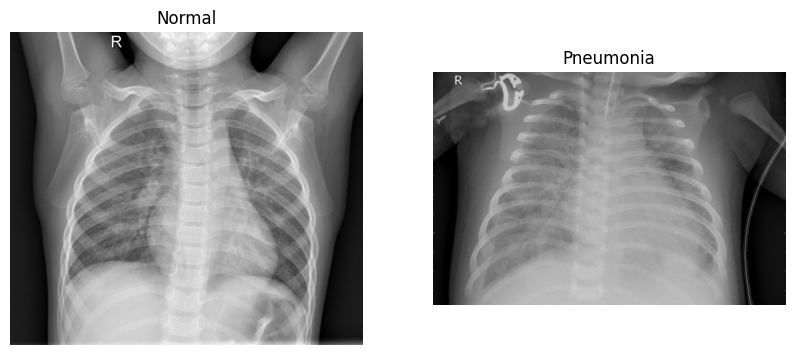

In [18]:
# Define paths to your data
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# Count the number of images in each class
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

num_normal_train = len(os.listdir(train_normal_dir))
num_pneumonia_train = len(os.listdir(train_pneumonia_dir))

print(f"--- Training Set Analysis ---")
print(f"Number of Normal images: {num_normal_train}")
print(f"Number of Pneumonia images: {num_pneumonia_train}")
print(f"Total training images: {num_normal_train + num_pneumonia_train}")

# Visualize a sample from each class
def find_first_image(directory):
    """Finds the first valid image file in a directory."""
    for filename in sorted(os.listdir(directory)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            return os.path.join(directory, filename)
    return None

# Load one of each
normal_img_path = find_first_image(train_normal_dir)
pneumonia_img_path = find_first_image(train_pneumonia_dir)

if normal_img_path and pneumonia_img_path:
    normal_img = cv2.imread(normal_img_path)
    pneumonia_img = cv2.imread(pneumonia_img_path)

    # Display the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB))
    plt.title('Normal')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(pneumonia_img, cv2.COLOR_BGR2RGB))
    plt.title('Pneumonia')
    plt.axis('off')

    plt.show()
else:
    print("Could not find sample images to display.")


<h3>Data Preparation & Augmentation</h3>

In [19]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Loading & Preprocessing Pipeline
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.class_names

# Data Augmentation Layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

# Preprocessing function for VGG16
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Create the final data pipelines
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configure for performance
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


<h3>Building the Model with Transfer Learning</h3>

In [20]:
# Model Building (Functional API)
input_shape = IMG_SIZE + (3,)
inputs = tf.keras.Input(shape=input_shape)
base_model = tf.keras.applications.VGG16(input_tensor=inputs, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

<h3>Training the Model</h3>


Starting model training...
Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9728 - loss: 0.0732 - val_accuracy: 0.8750 - val_loss: 0.2143 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.9780 - loss: 0.0570 - val_accuracy: 0.8750 - val_loss: 0.2002 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.9842 - loss: 0.0454 - val_accuracy: 0.8750 - val_loss: 0.1663 - learning_rate: 0.0010
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9789 - loss: 0.0603 - val_accuracy: 0.8750 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9845 - loss: 0.0430 - val_accuracy: 0.8750 - val_loss: 0.3541 - learning_rate: 0.0010
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.9830 - loss: 0.0497 - val_accuracy: 0.8750 - val_loss: 0.2461 - learning_rate: 2.0000e-04
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━

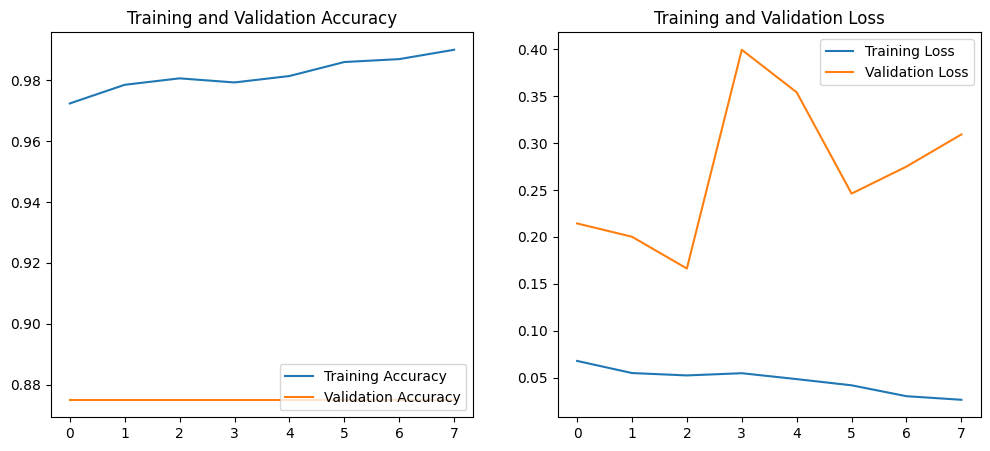

In [27]:
# Calculate Class Weights
num_normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
total_train_samples = num_normal_train + num_pneumonia_train
weight_for_normal = (1 / num_normal_train) * (total_train_samples / 2.0)
weight_for_pneumonia = (1 / num_pneumonia_train) * (total_train_samples / 2.0)
class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=5,              # Stop training after 5 epochs with no improvement
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # Reduce learning rate by a factor of 5 if it plateaus
    patience=2,
    min_lr=1e-6
)

print("\nStarting model training...")
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)

# Visualize Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

There is a noticeable gap between the training curves (blue) and the validation curves (orange). The training accuracy is much higher than the validation accuracy. This is a classic sign of overfitting

<h3>Final Evaluation on the Test Set</h3>

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate Final Model on Test Set
print("\n--- Evaluating Final Model on Test Set... ---")

# Evaluate the model to get loss and accuracy
loss, accuracy = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Get the true labels and predicted labels for the entire test set
y_true = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Print the detailed classification report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Print the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print("              Predicted")
print("             Normal  Pneumonia")
print(f"Actual Normal:    {cm[0]}")
print(f"Actual Pneumonia: {cm[1]}")


--- Evaluating Final Model on Test Set... ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7202 - loss: 1.5174

Test Accuracy: 84.29%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.95      0.61      0.74       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624


--- Confusion Matrix ---
              Predicted
             Normal  Pneumonia
Actual Normal:    [143  91]
Actual Pneumonia: [  7 383]


<h3>Analysis of Model's Performance</h3>
Overall Accuracy (84.29%): This is a solid score.

The most important metric, recall for PNEUMONIA, is 98%. This is excellent. It means your model is extremely effective at its primary goal: correctly identifying patients who have the disease. It is very unlikely to miss a case, making it clinically very "safe."

The recall for NORMAL, which is 61%. This means the model incorrectly flags a significant number of healthy patients as having pneumonia (a "false positive"). While this is not ideal, it is a much less dangerous error than missing an actual case of the disease.

<h3>Explainability with Grad-CAM</h3>

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_42']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


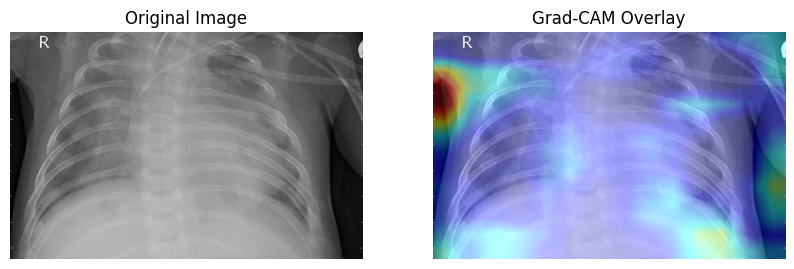

In [30]:
# Grad-CAM Implementation
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return tf.keras.applications.vgg16.preprocess_input(array)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.show()

# Find the last conv layer in the base model
last_conv_layer_name = "block5_conv3"

# Select a PNEUMONIA image from the test set to explain
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')
pneumonia_img_path = os.path.join(test_pneumonia_dir, os.listdir(test_pneumonia_dir)[0])
img_array = get_img_array(pneumonia_img_path, size=IMG_SIZE)

# Generate and Display the Heatmap
model.layers[-1].activation = None
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(pneumonia_img_path, heatmap)

- The image on the left is the original X-ray, which the model correctly identified as "Pneumonia."

- The image on the right shows the Grad-CAM heatmap. The "hot" areas (in red and yellow) are the specific regions the model focused on to make its decision.

In [32]:
import tensorflow as tf

# Restore the correct activation function to the last layer
model.layers[-1].activation = tf.keras.activations.sigmoid

# Save the corrected model
model.save("pneumonia_classifier_model.keras")

print("✅ Model saved successfully with the correct activation function.")

✅ Model saved successfully with the correct activation function.
